In [166]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

In [2]:
spark

In [3]:
badges = spark.read.parquet('/data/stackoverflow/Badges')

In [4]:
badges.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- UserId: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Class: integer (nullable = true)
 |-- TagBased: boolean (nullable = true)



In [5]:
badges.count()

32450580

## Odczyt danych

In [6]:
badges.first()

Row(Id=82946, UserId=3718, Name='Teacher', Date=datetime.datetime(2008, 9, 15, 8, 55, 3, 923000), Class=3, TagBased=False)

In [7]:
badges.first().Name == 'Teacher'

True

In [8]:
badges.show(3)

+-----+------+-------+--------------------+-----+--------+
|   Id|UserId|   Name|                Date|Class|TagBased|
+-----+------+-------+--------------------+-----+--------+
|82946|  3718|Teacher|2008-09-15 08:55:...|    3|   false|
|82947|   994|Teacher|2008-09-15 08:55:...|    3|   false|
|82949|  3893|Teacher|2008-09-15 08:55:...|    3|   false|
+-----+------+-------+--------------------+-----+--------+
only showing top 3 rows



In [9]:
badges.show(3, truncate=False)

+-----+------+-------+-----------------------+-----+--------+
|Id   |UserId|Name   |Date                   |Class|TagBased|
+-----+------+-------+-----------------------+-----+--------+
|82946|3718  |Teacher|2008-09-15 08:55:03.923|3    |false   |
|82947|994   |Teacher|2008-09-15 08:55:03.957|3    |false   |
|82949|3893  |Teacher|2008-09-15 08:55:03.957|3    |false   |
+-----+------+-------+-----------------------+-----+--------+
only showing top 3 rows



In [10]:
first_5_records = badges.take(5)
first_5_records[-1]

Row(Id=82951, UserId=5196, Name='Teacher', Date=datetime.datetime(2008, 9, 15, 8, 55, 3, 957000), Class=3, TagBased=False)

In [11]:
badges.limit(300).toPandas()

,Id,UserId,Name,Date,Class,TagBased
0,82946,3718,Teacher,2008-09-15 08:55:03.923,3,False
1,82947,994,Teacher,2008-09-15 08:55:03.957,3,False
2,82949,3893,Teacher,2008-09-15 08:55:03.957,3,False
3,82950,4591,Teacher,2008-09-15 08:55:03.957,3,False
4,82951,5196,Teacher,2008-09-15 08:55:03.957,3,False
...,...,...,...,...,...,...
295,83421,3289,Teacher,2008-09-15 08:55:03.957,3,False
296,83422,2688,Teacher,2008-09-15 08:55:03.957,3,False
297,83423,3622,Teacher,2008-09-15 08:55:03.957,3,False
298,83424,698,Teacher,2008-09-15 08:55:03.957,3,False


In [12]:
badges_with_limit = badges.limit(2)
badges_with_limit.collect()

[Row(Id=82946, UserId=3718, Name='Teacher', Date=datetime.datetime(2008, 9, 15, 8, 55, 3, 923000), Class=3, TagBased=False),
 Row(Id=82947, UserId=994, Name='Teacher', Date=datetime.datetime(2008, 9, 15, 8, 55, 3, 957000), Class=3, TagBased=False)]

In [13]:
badges.take(2)

[Row(Id=82946, UserId=3718, Name='Teacher', Date=datetime.datetime(2008, 9, 15, 8, 55, 3, 923000), Class=3, TagBased=False),
 Row(Id=82947, UserId=994, Name='Teacher', Date=datetime.datetime(2008, 9, 15, 8, 55, 3, 957000), Class=3, TagBased=False)]

## Selekcja danych (`WHERE`)

In [14]:
condition = 'Class = 1' # 1 means gold badge
badges.where(condition).count()

892514

In [15]:
condition = badges.Class == 1
print(condition)
badges.where(condition).count()

Column<b'(Class = 1)'>


892514

In [16]:
condition = col('Class') == 1
print(condition)
badges.where(condition).count()

Column<b'(Class = 1)'>


892514

In [17]:
badges.where(condition).first()

Row(Id=100568, UserId=30, Name='Great Question', Date=datetime.datetime(2008, 9, 15, 8, 55, 13, 720000), Class=1, TagBased=False)

In [18]:
gold_badge = col('Class') == 1
silver_badgs = col('Class') == 2
badges.where(gold_badge | silver_badgs).count()

7473443

In [19]:
gold_or_silber_badge = col('Class').isin(1, 2)
badges.where(gold_or_silber_badge).count()

7473443

In [20]:
not_gold_or_silber_badge = ~col('Class').isin(1, 2) # ticket no
badges.where(gold_or_silber_badge).count()

7473443

In [21]:
badges.where(col('Class') == 1).count()

892514

In [22]:
badges.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- UserId: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Class: integer (nullable = true)
 |-- TagBased: boolean (nullable = true)



In [23]:
badges.where(col('TagBased')).count()
badges.where(col('TagBased') == True).count()
badges.where('TagBased').count()

179785

In [24]:
badges.where(~col('TagBased')).count()

32270795

In [25]:
badges.where(col('TagBased').isNull()).count()

0

In [26]:
badges.where(col('TagBased').isNotNull()).count()

32450580

In [27]:
badges

DataFrame[Id: int, UserId: int, Name: string, Date: timestamp, Class: int, TagBased: boolean]

In [28]:
badges.where(col('Name') == 'Teacher').count()

1457324

In [29]:
badges.where(col('Name').like('T%')).count()

2715940

In [30]:
badges.where(col('Name').rlike('^[Tt]')).count()

2718934

In [31]:
%%time
badges.where(col('name') == 'Teacher').count()

CPU times: user 3.75 ms, sys: 3.19 ms, total: 6.94 ms
Wall time: 1.03 s


1457324

In [32]:
%%time
badges.where(lower(col('name')) == 'teacher').count()

CPU times: user 2.61 ms, sys: 3.26 ms, total: 5.87 ms
Wall time: 1.64 s


1457324

In [33]:
badges

DataFrame[Id: int, UserId: int, Name: string, Date: timestamp, Class: int, TagBased: boolean]

In [34]:
badges.where(year('Date') == '2019').count()

2906724

In [35]:
badges.where(col('Date').cast('date').between('2019-01-10', '2019-01-17')).count()

91546

`YYYY-MM-DD HH:MM:SS.sss`

In [36]:
badges.where(col('Date').cast('date').between('2019-01-10', '2019-01-17')).first()

Row(Id=30881586, UserId=10895603, Name='Editor', Date=datetime.datetime(2019, 1, 14, 10, 30, 14, 73000), Class=3, TagBased=False)

## Projekcja danych (`SELECT`)

In [37]:
badges.select('Name').show()

+-------+
|   Name|
+-------+
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
|Teacher|
+-------+
only showing top 20 rows



In [38]:
columns_to_select = ['UserId', 'Name']
badges.select(columns_to_select).show(10)

+------+-------+
|UserId|   Name|
+------+-------+
|  3718|Teacher|
|   994|Teacher|
|  3893|Teacher|
|  4591|Teacher|
|  5196|Teacher|
|  2635|Teacher|
|  1113|Teacher|
|  4182|Teacher|
|   164|Teacher|
|   652|Teacher|
+------+-------+
only showing top 10 rows



#### pokaż 10 wierszy UserId + Name, gdzie name to nie "Teacher"

1. `!=`: `col('Name') != "Teacher"`
2. `~(col('Name') == "Teacher")`
3. `(col('Name') > "Teacher") | (col('Name') < "Teacher")`

Kolejność

1. `select().where()`
2. `where().select()`

In [39]:
badges.where(col('Name')!='Teacher').select('UserId', 'Name').explain()

== Physical Plan ==
*(1) Project [UserId#1, Name#2]
+- *(1) Filter (isnotnull(Name#2) && NOT (Name#2 = Teacher))
   +- *(1) FileScan parquet [UserId#1,Name#2] Batched: true, Format: Parquet, Location: InMemoryFileIndex[hdfs://namenode:9000/data/stackoverflow/Badges], PartitionFilters: [], PushedFilters: [IsNotNull(Name), Not(EqualTo(Name,Teacher))], ReadSchema: struct<UserId:int,Name:string>


In [40]:
df_with_new_columns = badges.withColumn('is_gold', col('Class') == 1) \
    .withColumn('year', year('Date'))

In [41]:
df_with_new_columns.where(col('is_gold')).count()

892514

In [42]:
df_with_new_columns.drop('Date').first()

Row(Id=82946, UserId=3718, Name='Teacher', Class=3, TagBased=False, is_gold=False, year=2008)

In [43]:
df_with_new_columns.select('Id', 'UserId', 'year', month('Date').alias('month')).first()

Row(Id=82946, UserId=3718, year=2008, month=9)

## Agregacje

In [44]:
badges.select('Name').distinct().count()

5567

In [45]:
badges.select('Name').distinct().show()

+--------------------+
|                Name|
+--------------------+
|              bazaar|
|              iframe|
|             jbutton|
|    android-manifest|
|           standards|
|               input|
|     language-lawyer|
|           sitecore8|
|                rxjs|
|                 avx|
|hyperledger-composer|
|             mailkit|
|                xlrd|
|           arguments|
|                 fog|
|    fluent-interface|
|        google-earth|
|     instruction-set|
|       webdriverwait|
|      caliburn.micro|
+--------------------+
only showing top 20 rows



In [46]:
badges.where(~col('TagBased')).select('Name').distinct().count()

91

In [47]:
# znajdź najpopularniejsze badge ogólne

In [48]:
badges.where(~col('TagBased')).groupBy('Name').agg(count('*')).show()

+-----------------+--------+
|             Name|count(1)|
+-----------------+--------+
|      Commentator|  914556|
|       Electorate|   20574|
|        Explainer|   63978|
|       Civic Duty|   94622|
|       Tumbleweed| 1156958|
|             Guru|  130077|
|    Peer Pressure|  224148|
|      Mortarboard|   31565|
|          Revival|  388347|
|          Student| 2257156|
|    Nice Question|  581899|
|       Enthusiast|  215938|
|    Archaeologist|    2200|
|       Benefactor|   43252|
|          Sheriff|      43|
|          Fanatic|   32558|
|          Teacher| 1457324|
|Favorite Question|   50756|
|        Excavator|  136997|
|           Census|  127122|
+-----------------+--------+
only showing top 20 rows



In [49]:
badges.where(~col('TagBased')).groupBy('Name').count().show()

+-----------------+-------+
|             Name|  count|
+-----------------+-------+
|      Commentator| 914556|
|       Electorate|  20574|
|        Explainer|  63978|
|       Civic Duty|  94622|
|       Tumbleweed|1156958|
|             Guru| 130077|
|    Peer Pressure| 224148|
|      Mortarboard|  31565|
|          Revival| 388347|
|          Student|2257156|
|    Nice Question| 581899|
|       Enthusiast| 215938|
|    Archaeologist|   2200|
|       Benefactor|  43252|
|          Sheriff|     43|
|          Fanatic|  32558|
|          Teacher|1457324|
|Favorite Question|  50756|
|        Excavator| 136997|
|           Census| 127122|
+-----------------+-------+
only showing top 20 rows



In [50]:
badges.sort?

In [51]:
spark.sparkContext.setJobGroup('aaa', 'bbb') # for nicer descriptions in Spark UI

In [52]:
badges.where(~col('TagBased')).groupBy('Name').count().orderBy(desc('count')).show()

+----------------+-------+
|            Name|  count|
+----------------+-------+
|Popular Question|4526111|
|          Editor|2297538|
|         Student|2257156|
|Notable Question|2230290|
|        Informed|2179709|
|         Scholar|1847021|
|        Yearling|1677778|
|         Teacher|1457324|
|       Supporter|1352041|
|     Nice Answer|1200408|
|      Tumbleweed|1156958|
|  Autobiographer| 953335|
|     Commentator| 914556|
|       Custodian| 826981|
|          Caucus| 664845|
| Famous Question| 645355|
|   Nice Question| 581899|
|     Necromancer| 567598|
|     Good Answer| 411794|
|         Revival| 388347|
+----------------+-------+
only showing top 20 rows



In [53]:
badges.agg(max('Date')).first()

Row(max(Date)=datetime.datetime(2019, 9, 1, 8, 35, 21, 237000))

In [59]:
# ile było badgy w każdym roku?
badges_by_year = badges.groupBy(year('Date').alias('year')).count().orderBy('year')
badges_by_year.show()

+----+-------+
|year|  count|
+----+-------+
|2008| 101034|
|2009| 342511|
|2010| 657391|
|2011|1258253|
|2012|2357522|
|2013|3314257|
|2014|3944886|
|2015|4295919|
|2016|4393673|
|2017|4614041|
|2018|4264369|
|2019|2906724|
+----+-------+



In [66]:
%matplotlib notebook

<IPython.core.display.Javascript object>


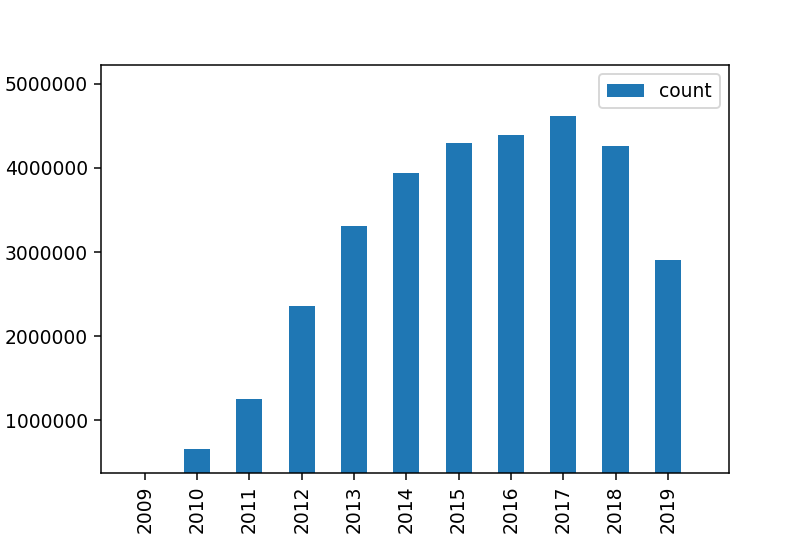

In [67]:
badges_by_year.toPandas().plot(x='year', y='count', kind='bar')

<IPython.core.display.Javascript object>


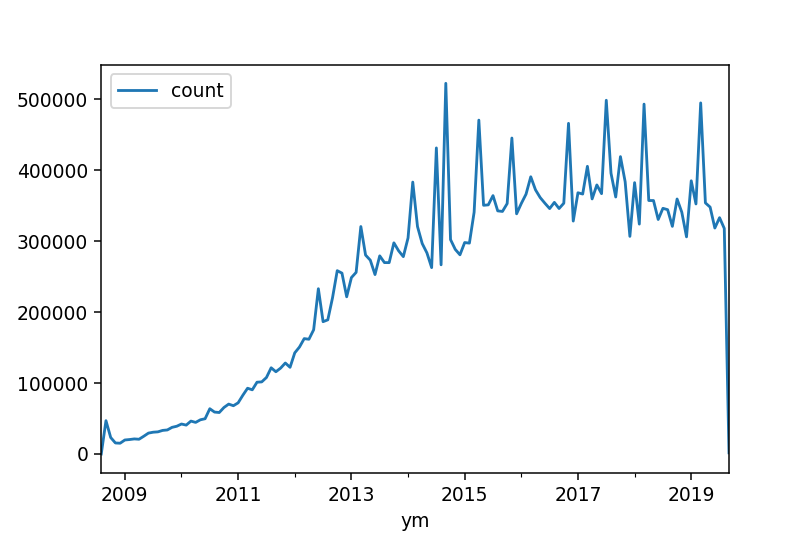

In [71]:
badges_per_month = badges \
    .withColumn('ym', date_trunc('MONTH', 'Date')) \
    .groupBy('ym').count().orderBy('ym')
badges_per_month.toPandas().plot(x='ym', y='count')

In [72]:
badges.describe().show()

+-------+--------------------+------------------+-------------------+------------------+
|summary|                  Id|            UserId|               Name|             Class|
+-------+--------------------+------------------+-------------------+------------------+
|  count|            32450580|          32450580|           32450580|          32450580|
|   mean|1.6993170950797334E7|3156918.6639716453| 2.9444444444444446|2.7421939145617737|
| stddev|    9684297.29315046|3021906.4844881576|0.23570226039551592|0.4963362763093083|
|    min|               82946|                -1|          .htaccess|                 1|
|    max|            33682095|          12005345|              zxing|                 3|
+-------+--------------------+------------------+-------------------+------------------+



In [74]:
badges.where(col('UserId') == -1).first()

Row(Id=20468086, UserId=-1, Name='Not a Robot', Date=datetime.datetime(2016, 10, 3, 14, 49, 10), Class=2, TagBased=False)

In [76]:
badges.where(col('Name') == 'pyspark') \
    .where(col('Class') == 1).show()

+--------+-------+-------+--------------------+-----+--------+
|      Id| UserId|   Name|                Date|Class|TagBased|
+--------+-------+-------+--------------------+-----+--------+
|18849470|1560062|pyspark|2016-05-31 04:01:...|    1|    true|
|31239823|6910411|pyspark|2019-02-08 18:16:...|    1|    true|
+--------+-------+-------+--------------------+-----+--------+



## Łączenie zbiorów (`JOIN`)

In [77]:
! ls

big_data_technologies.csv  pyspark-intro.ipynb	python-intro.ipynb


In [78]:
! pwd

/home/jovyan/work


In [93]:
path = 'file:///home/jovyan/work/big_data_technologies.csv'
big_data_technologies = spark.read.csv(path).toDF('technology')

In [94]:
big_data_technologies.count()

20

In [101]:
joined = badges.join(big_data_technologies, 
                     lower(big_data_technologies.technology) == lower(badges.Name))

In [102]:
joined.count()

10258

In [104]:
%matplotlib inline

<IPython.core.display.Javascript object>


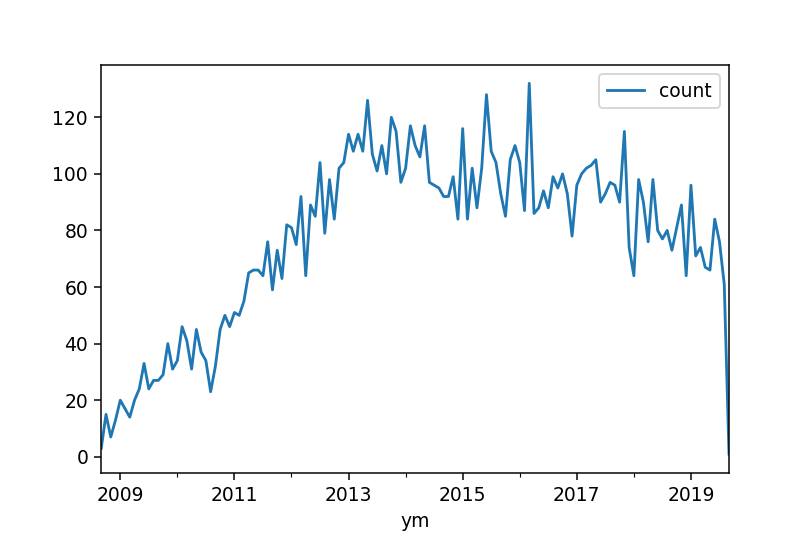

In [103]:
joined \
    .withColumn('ym', date_trunc('MONTH', 'Date')) \
    .groupBy('ym').count().orderBy('ym') \
    .toPandas().plot(x='ym', y='count')

<IPython.core.display.Javascript object>


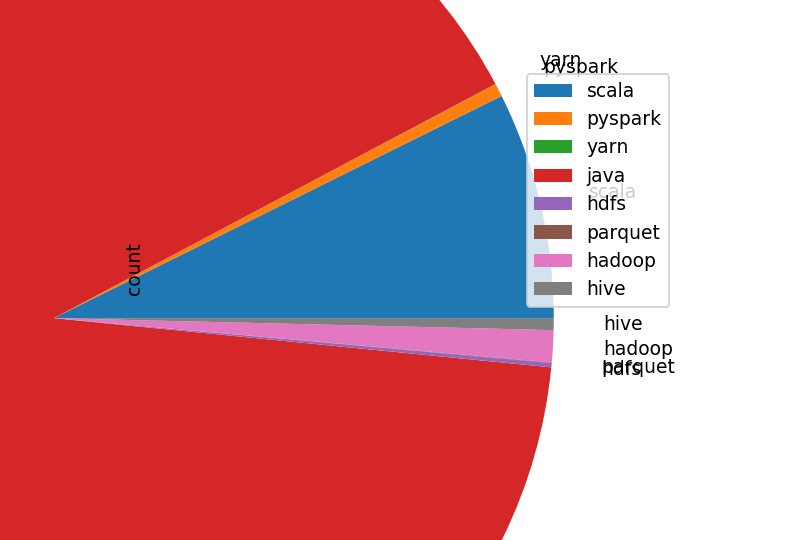

In [120]:
data = joined.groupBy('technology').count().toPandas()
data.set_index('technology').plot(y='count', kind='pie')

In [122]:
joined = badges.join(broadcast(big_data_technologies), 
                     lower(big_data_technologies.technology) == lower(badges.Name))
joined.explain()

== Physical Plan ==
*(2) BroadcastHashJoin [lower(Name#2)], [lower(technology#1037)], Inner, BuildRight
:- *(2) FileScan parquet [Id#0,UserId#1,Name#2,Date#3,Class#4,TagBased#5] Batched: true, Format: Parquet, Location: InMemoryFileIndex[hdfs://namenode:9000/data/stackoverflow/Badges], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Id:int,UserId:int,Name:string,Date:timestamp,Class:int,TagBased:boolean>
+- BroadcastExchange HashedRelationBroadcastMode(List(lower(input[0, string, true])))
   +- *(1) Project [_c0#1035 AS technology#1037]
      +- *(1) FileScan csv [_c0#1035] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/jovyan/work/big_data_technologies.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<_c0:string>


### SEMI JOIN

Wybierz z lewej strony tylko te wiersze, które by się zjoinowały z prawą stroną

### ANTI JOIN

Wybierz z lewej strony tylko te wiersze, które by się **NIE** zjoinowały z prawą stroną


In [127]:
joined = badges.join(broadcast(big_data_technologies), 
                     lower(big_data_technologies.technology) == lower(badges.Name), 'leftsemi')
joined.count()

10258

In [128]:
joined = badges.join(broadcast(big_data_technologies), 
                     lower(big_data_technologies.technology) == lower(badges.Name), 'leftanti')
joined.count()

32440322

## Praca z oknami danych

Jaki był pierwszy badge otrzymany przez użytkownika? - dla wszystkich

|UserId|FirstAwarededBadge|WhenAwareded|
|-----|---|--|
|100|Student|2019-09-01|
|101|Teacher|2019-09-24|

In [131]:
w = Window.partitionBy('UserId').orderBy('Date')

In [143]:
first_badges = badges \
    .withColumn('badge_order', row_number().over(w)) \
    .where(col('badge_order') == 1) \
    .select(
        'UserId',
        col('Name').alias('FirstAwardedBadge'),
        col('Date').cast('date').alias('WhenAwarded')
    ).cache()

first_badges.show(10)

+------+-----------------+-----------+
|UserId|FirstAwardedBadge|WhenAwarded|
+------+-----------------+-----------+
|   148|          Teacher| 2008-09-15|
|   463|          Teacher| 2008-09-15|
|   833|          Teacher| 2008-09-16|
|  1088|          Teacher| 2008-09-15|
|  1238|          Teacher| 2008-09-15|
|  1580|          Teacher| 2008-09-15|
|  1591|   Autobiographer| 2008-09-15|
|  1645|          Teacher| 2008-09-15|
|  1959|          Teacher| 2008-09-15|
|  2122|          Student| 2008-09-15|
+------+-----------------+-----------+
only showing top 10 rows



In [149]:
first_badges.groupBy('FirstAwardedBadge').count().orderBy(desc('count')).show()

+-----------------+-------+
|FirstAwardedBadge|  count|
+-----------------+-------+
|         Informed|1798132|
|           Editor| 920215|
|          Student| 878321|
|          Teacher| 535933|
|          Scholar| 453355|
|       Tumbleweed| 323596|
|   Autobiographer| 311213|
|        Custodian|  94085|
| Popular Question|  67550|
|    Peer Pressure|  34688|
|        Supporter|  23847|
|       Enthusiast|  18887|
|      Commentator|  15216|
|           Census|  13149|
|       Analytical|   5718|
|   Citizen Patrol|   4612|
|          Cleanup|   3099|
|          Revival|   1844|
|        Announcer|   1736|
|        Organizer|   1237|
+-----------------+-------+
only showing top 20 rows



In [150]:
first_badges.where(col('FirstAwardedBadge') == 'c#').show()

+------+-----------------+-----------+
|UserId|FirstAwardedBadge|WhenAwarded|
+------+-----------------+-----------+
|310574|               c#| 2010-03-28|
|414076|               c#| 2010-03-29|
|  1965|               c#| 2008-09-10|
|   905|               c#| 2008-09-07|
|410636|               c#| 2010-06-04|
+------+-----------------+-----------+



## User Defined Functions

Built-in functions: https://spark.apache.org/docs/2.3.0/api/python/pyspark.sql.html#module-pyspark.sql.functions

In [151]:
first_badges.count()

5509344

In [163]:
def glue(user_id, badge_name):
    if user_id is None or badge_name is None:
        return None
    return str(user_id) + ';;;' + str(badge_name)

assert glue(100, 'c#') == '100;;;c#'
assert glue(None, 'c#') is None
assert glue(100, None) is None
assert glue(None, None) is None

In [168]:
create_pk = udf(glue, StringType())

In [171]:
first_badges.withColumn('pk', create_pk('UserId', 'FirstAwardedBadge')).show()

+------+-----------------+-----------+--------------------+
|UserId|FirstAwardedBadge|WhenAwarded|                  pk|
+------+-----------------+-----------+--------------------+
|   148|          Teacher| 2008-09-15|       148;;;Teacher|
|   463|          Teacher| 2008-09-15|       463;;;Teacher|
|   833|          Teacher| 2008-09-16|       833;;;Teacher|
|  1088|          Teacher| 2008-09-15|      1088;;;Teacher|
|  1238|          Teacher| 2008-09-15|      1238;;;Teacher|
|  1580|          Teacher| 2008-09-15|      1580;;;Teacher|
|  1591|   Autobiographer| 2008-09-15|1591;;;Autobiogra...|
|  1645|          Teacher| 2008-09-15|      1645;;;Teacher|
|  1959|          Teacher| 2008-09-15|      1959;;;Teacher|
|  2122|          Student| 2008-09-15|      2122;;;Student|
|  2659|          Teacher| 2008-09-15|      2659;;;Teacher|
|  3175|          Student| 2008-09-15|      3175;;;Student|
|  3749|          Teacher| 2008-09-15|      3749;;;Teacher|
|  3997|          Teacher| 2008-09-15|  

## Saving the data

In [173]:
first_badges.explain()

== Physical Plan ==
InMemoryTableScan [UserId#1, FirstAwardedBadge#1677, WhenAwarded#1678]
   +- InMemoryRelation [UserId#1, FirstAwardedBadge#1677, WhenAwarded#1678], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(3) Project [UserId#1, Name#2 AS FirstAwardedBadge#1677, cast(Date#3 as date) AS WhenAwarded#1678]
            +- *(3) Filter (isnotnull(badge_order#1669) && (badge_order#1669 = 1))
               +- Window [row_number() windowspecdefinition(UserId#1, Date#3 ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS badge_order#1669], [UserId#1], [Date#3 ASC NULLS FIRST]
                  +- *(2) Sort [UserId#1 ASC NULLS FIRST, Date#3 ASC NULLS FIRST], false, 0
                     +- Exchange hashpartitioning(UserId#1, 200)
                        +- *(1) FileScan parquet [UserId#1,Name#2,Date#3] Batched: true, Format: Parquet, Location: InMemoryFileIndex[hdfs://namenode:9000/data/stackoverflow/Badges], PartitionFilters: [],

In [172]:
first_badges.withColumn('pk', create_pk('UserId', 'FirstAwardedBadge')) \
    .write.csv('/data/stackoveflow/first_badge')

In [178]:
first_badges.withColumn('pk', create_pk('UserId', 'FirstAwardedBadge')) \
    .repartition(9).write.csv('/data/stackoveflow/first_badge_rep_9.csv')

In [179]:
first_badges.withColumn('pk', create_pk('UserId', 'FirstAwardedBadge')) \
    .coalesce(9).write.csv('/data/stackoveflow/first_badge_coalesce_9.csv')

In [183]:
first_badges.withColumn('pk', create_pk('UserId', 'FirstAwardedBadge')) \
    .write.partitionBy('FirstAwardedBadge').csv('/data/stackoveflow/first_badge_by_tag')

In [184]:
spark.read.csv('/data/stackoveflow/first_badge_by_tag')

DataFrame[_c0: string, _c1: string, _c2: string, FirstAwardedBadge: string]

In [185]:
first_badges.withColumn('pk', create_pk('UserId', 'FirstAwardedBadge')) \
    .repartition('FirstAwardedBadge') \
    .write.partitionBy('FirstAwardedBadge').csv('/data/stackoveflow/first_badge_by_tag_rep9')

In [187]:
spark.read.csv('/data/stackoveflow/first_badge_by_tag_rep9')

DataFrame[_c0: string, _c1: string, _c2: string, FirstAwardedBadge: string]